# Make multiwavelength light curves using archival data
***

## Learning Goals    
By the end of this tutorial, you will be able to:
 - automatically load a catalog of sources
 - automatically search NASA and non-NASA resources for light curves
 - store light curves in a Pandas multiindex dataframe
 - plot all light curves on the same plot
 
 
## Introduction:
 - A user has a sample of interesting targets for which they would like to see a plot of available archival light curves.  We start with a small set of changing look AGN from Yang et al., 2018, which are automatically downloaded. Changing look AGN are cases where the broad emission lines appear or disappear (and not just that the flux is variable). We model light curve plots after van Velzen et al. 2021.  We search through a curated list of time-domain NASA holdings as well as non-NASA sources.  HEASARC catalogs used are Fermi and Beppo-Sax, IRSA catalogs used are ZTF and WISE, and MAST catalogs used are Pan-Starrs, TESS, Kepler, and K2.  Non-NASA sources are Gaia and IceCube. This list is hopefully generalized enough to include many types of targets to make this notebook interesting for many types of science.  All of these time-domain archives are searched in an automated fashion using astroquery.
 - Light curve data storage is a tricky problem.  Currently we are using a multi-index Pandas dataframe, but it is not clear that this is the best choice or the best choice for scaling up.  One downside is that we need to manually track the units of flux and time instead of relying on an astropy storage scheme which would be able to do the units worrying for us.  Astropy does not currently have a good option for multi band light curve storage.
 - We intend to explore a ML classifier for these changing look AGN light curves.
 
## Input:
 - a catalog of CLAGN from the literature

## Output:
 - an archival optical + IR + neutrino light curve
 
## Technical Goals:
 - should be able to run from a clean checkout from github
 - should be able to automatically download all catalogs & images used
 - need to have all photometry in the same physical unit
 - need to have a data structure that is easy to use but holds light curve information (time and units) and is extendable to ML applications
 - need to have a curated list of catalogs to search for photometry that is generalizeable to other input catalogs
 
## Non-standard Imports:
- `astroquery` to interface with archives APIs
- `astropy` to work with coordinates/units and data structures
- `AXS` (astronomy extensions for Spark) to handle large catalog cross matching
- `lightkurve` to search TESSS, Kepler, and K2 archives
- `urllib` to handle archive searches with website interface

## Authors:
IPAC SP team

## Acknowledgements:
Suvi Gezari, Antara Basu-zych,\
MAST, HEASARC, & IRSA Fornax teams



In [1]:
import numpy as np
import time
import pandas as pd
import axs
import os
import sys
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import requests
import pickle

from scipy import stats

from astroquery.ipac.ned import Ned
from astroquery.heasarc import Heasarc
from astroquery.gaia import Gaia

from astropy.coordinates import SkyCoord, name_resolve
import astropy.units as u
from astropy.table import Table, vstack, hstack, unique
from astropy.io import fits,ascii
from astropy.time import Time
from astropy.timeseries import TimeSeries


try: # Python 3.x
    from urllib.parse import quote as urlencode
    from urllib.request import urlretrieve
except ImportError:  # Python 2.x
    from urllib import pathname2url as urlencode
    from urllib import urlretrieve

try:
    import lightkurve as lk
except ImportError:
    !pip install lightkurve --upgrade
    import lightkurve as lk
        
try:
    from acstools import acszpt
except ImportError:
    !pip install acstools
    from acstools import acszpt

import warnings
warnings.filterwarnings('ignore')

try:
    from unTimely_Catalog_tools import unTimelyCatalogExplorer
except ImportError:
    if not os.path.exists('./unTimely_Catalog_explorer'):
        !git clone https://github.com/fkiwy/unTimely_Catalog_explorer.git
    sys.path.append('./unTimely_Catalog_explorer')
    from unTimely_Catalog_tools import unTimelyCatalogExplorer
    
import tempfile

# Local code imports
sys.path.append('code/')
from fluxconversions import convert_WISEtoJanskies, convertACSmagtoflux
from panstarrs import ps1cone, ps1search, checklegal, ps1metadata, addfilter, improve_filter_format, search_lightcurve
from clean_filternames import clean_filternames
from gaia_functions import Gaia_retrieve_EPOCH_PHOTOMETRY, Gaia_mk_lightcurves, Gaia_mk_MultiIndex
from HCV_functions import get_hscapiurl, hcvcone, hcvsearch, hcvmetadata, cat2url, checklegal_hcv
from mast_functions import resolve, mastQuery
from icecube_functions import get_icecube_catalog
from sample_selection import get_lamassa_sample, get_macleod16_sample, get_ruan_sample, get_macleod19_sample, get_sheng_sample, get_green_sample, get_lyu_sample, get_lopeznavas_sample, get_hon_sample, get_yang_sample, remove_duplicate_coords


## Plotting stuff
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelpad'] = 7
mpl.rcParams['xtick.major.pad'] = 7
mpl.rcParams['ytick.major.pad'] = 7
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.top'] = True
mpl.rcParams['xtick.minor.bottom'] = True
mpl.rcParams['ytick.minor.left'] = True
mpl.rcParams['ytick.minor.right'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
#mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['hatch.linewidth'] = 1

def_cols = plt.rcParams['axes.prop_cycle'].by_key()['color']


## NEW! LOAD/SAVE PICKLE FILE! ##
SAVEDF = False # if set to True, pickle file will be saved. If False, pickle file will be loaded.
pickle_file_name = "data/dflc_Krick_Feb232023.pkl" # name of pickle file (to be loaded or saved)
###


/opt/conda/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /home/jkrick/.lightkurve/cache. Please move all the files in the legacy directory /home/jkrick/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
#setup to save the light curves in a data structure
## From Brigitta
class MultibandTimeSeries(TimeSeries):
    def __init__(self, *, data=None, time=None, **kwargs):
        # using kwargs to swallow all other arguments a TimeSeries/QTable can have,
        # but we dont explicitly use. Ideally they are spelt out if we have docstrings here.
        # Also using keyword only arguments everywhere to force being explicit.
        super().__init__(data=data, time=time, **kwargs)
                
    def add_band(self, *, time=None, data=None, band_name="None"):
        '''Add a time, flux/mag data set and resort the arrays. ``time`` can be a TimeSeries instance'''
        if 'time' not in self.colnames:
            if isinstance(time, TimeSeries):
                super().__init__(time)
            else:
                super().__init__(data={band_name: data}, time=time)
        else:
            if time is None:
                # this assumes ``band_name`` fluxes are taken at the very same times as the already exitsing bands
                # TODO: include checks for sizes and other assumptions
                self[band_name] = data
                return 
            elif not isinstance(time, TimeSeries):
                # TODO: handle band_name=None case
                time = TimeSeries(time=time, data={band_name: data})
            super().__init__(vstack([self, time]))
            
            
## MultiIndex Pandas data frame object in which we can append the light curves:
class MultiIndexDFObject:
    '''
    Pandas data frame MultiIndex object. 
    - add(): append new MultiIndex light curve data frame.
    - .data returns the data.
    '''
    def __init__(self):
        pass
    
    def append(self,x):
        try:
            self.data
        except AttributeError:
            self.data = x.copy()
        else:
            self.data = pd.concat([self.data , x])
            
    def pickle(self,x):
        self.data.to_pickle(x)  
        
    def load_pickle(self,x):
        with open(x , "rb") as f:
            self.data = pickle.load(f)

### Initialize Pandas MultiIndex data frame for storing the light curve
df_lc = MultiIndexDFObject()

## 1. Define the Sample
 We define here a "gold" sample of spectroscopically confirmed changing look AGN and quasars. This sample includes both objects which change from type 1 to type 2 and also the opposite.  Future studies may want to treat these as seperate objects or seperate QSOs from AGN.
 
 Bibcodes for the samples used are listed next to their functions for reference.  
 
 Functions used to grab the samples from the papers use Astroquery, NED, SIMBAD, Vizier, and in a few cases grab the tables from the html versions of the paper.

In [3]:
#build up the sample
coords =[]
labels = []

#choose your own adventure:

#get_lamassa_sample(coords, labels)  #2015ApJ...800..144L
#get_macleod16_sample(coords, labels) #2016MNRAS.457..389M
#get_ruan_sample(coords, labels) #2016ApJ...826..188R
#get_macleod19_sample(coords, labels)  #2019ApJ...874....8M
#get_sheng_sample(coords, labels)  #2020ApJ...889...46S
#get_green_sample(coords, labels)  #2022ApJ...933..180G
#get_lyu_sample(coords, labels)  z32022ApJ...927..227L
#get_lopeznavas_sample(coords, labels)  #2022MNRAS.513L..57L
#get_hon_sample(coords, labels)  #2022MNRAS.511...54H
get_yang_sample(coords, labels)   #2018ApJ...862..109Y

#remove duplicates from the list if combining multiple references
coords, labels = remove_duplicate_coords(coords, labels)

## 2. Find light curves for these targets in NASA catalogs
- data access:
    - work with a curated list of catalogs for each archive
        - focus on general surveys
        - this list is appropriate for a generalization of this use case to other input catalogs


### 2.1 HEASARC: FERMI & Beppo SAX


In [ ]:
mission_list = ['FERMIGTRIG', 'SAXGRBMGRB']
radius = 0.1*u.degree
#for testing
#for ccount in range(1):
    #To get a fermigtrig source
    #coord = SkyCoord('03h41m21.2s -89d00m33.0s', frame='icrs')

    #to get a bepposax source
    #coord = SkyCoord('14h32m00.0s -88d00m00.0s', frame='icrs')

for ccount, coord in enumerate(coords_list):
    #use astroquery to search that position for either a Fermi or Beppo Sax trigger
    for mcount, mission in enumerate(mission_list):
        try:
            results = Heasarc.query_region(coord, mission = mission, radius = radius)#, sortvar = 'SEARCH_OFFSET_')
            #really just need to save the one time of the Gamma ray detection
            #time is already in MJD for both catalogs
            if mission == 'FERMIGTRIG':
                time_mjd = float(results['TRIGGER_TIME'])
            else:
                time_mjd = float(results['TIME'][0])
                
            type(time_mjd)

            #really just need to mark this spot with a vertical line in the plot
            dfsingle = pd.DataFrame(dict(flux=[0.1], err=[0.1], time=[time_mjd], objectid=[ccount + 1], band=[mission])).set_index(["objectid", "band", "time"])
            
            # Append to existing MultiIndex light curve object
            df_lc.append(dfsingle)

        except AttributeError:
            print("no results at that location for ", mission)


#**** These HEASARC searches are returning an attribute error because of an astroquery bug
# bug submitted to astroquery Oct 18, waiting for a fix.
# if that gets fixed, can probably change this cell 

### 2.2 IRSA: ZTF

In [8]:
%%time
#python package ztfquery is not a good solution for this because it requires IRSA password
#Instead will construct the URL for an API query
#https://irsa.ipac.caltech.edu/docs/program_interface/ztf_lightcurve_api.html
ztf_radius = 0.000278   #as suggested by Dave Shupe

for ccount, coord in enumerate(coords_list):
    #doesn't take SkyCoord
    ra = CLAGN['RA'][ccount]
    dec = CLAGN['DEC'][ccount]
    #make the string for the URL query
    #ask for all three bands (g, r, i)
    #don't want data that is flagged as unusable by the ZTF pipeline
    urlstr = 'https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE %f %f %f&BANDNAME=g,r,i&FORMAT=ipac_table&BAD_CATFLAGS_MASK=32768'%(ra, dec,ztf_radius)

    response = requests.get(urlstr)
    if response.ok:
        ztf_lc = ascii.read(response.text, format='ipac')
        print('object '+str(ccount)+' , unique ztf IDs:'+str(len(np.unique(ztf_lc['oid'])))+',in '+str(len(np.unique(ztf_lc['filtercode'])))+' filters')
        # reading in indecies of unique IDs to do coordinate match and find dif magnitudes of same objects 
        idu,inds = np.unique(ztf_lc['oid'],return_index=True)
        #plt.figure(figsize=(6,4))
        for nn,idd in enumerate(idu):
            sel = (ztf_lc['oid']==idd)
            
            flux = 10**((ztf_lc['mag'][sel] - 23.9)/(-2.5))  #now in uJy [Based on ztf paper https://arxiv.org/pdf/1902.01872.pdf zeropoint corrections already applied]
            magupper = ztf_lc['mag'][sel] + ztf_lc['magerr'][sel]
            maglower = ztf_lc['mag'][sel] - ztf_lc['magerr'][sel]
            flux_upper = abs(flux - (10**((magupper - 23.9)/(-2.5))))
            flux_lower =  abs(flux - (10**((maglower - 23.9)/(-2.5))))
            fluxerr = (flux_upper + flux_lower) / 2.0
            
            flux = flux * (1E-3) # now in mJy
            fluxerr = fluxerr * (1E-3) # now in mJy
            
            #plt.errorbar(np.round(ztf_lc['mjd'][sel],0),flux,yerr=fluxerr,marker='.',linestyle='',label=ztf_lc['filtercode'][sel][0])
            #plt.legend()
            
  
            # add to df_lc
            dfsingle = pd.DataFrame(dict(flux=flux, err=fluxerr, time=ztf_lc['mjd'][sel], objectid=np.ones_like(ztf_lc['mag'][sel])*(ccount+1), band=ztf_lc['filtercode'][sel])).set_index(["objectid", "band", "time"])
            df_lc.append(dfsingle)

        #plt.show()
    
    else:
        print(ccount, " There is no ZTF light curve for object"+str(ccount))

object 0 , unique ztf IDs:3,in 3 filters
object 1 , unique ztf IDs:2,in 2 filters
object 2 , unique ztf IDs:5,in 3 filters
object 3 , unique ztf IDs:5,in 3 filters
object 4 , unique ztf IDs:4,in 3 filters
object 5 , unique ztf IDs:5,in 3 filters
object 6 , unique ztf IDs:6,in 3 filters
object 7 , unique ztf IDs:4,in 2 filters
object 8 , unique ztf IDs:8,in 3 filters
object 9 , unique ztf IDs:5,in 3 filters
object 10 , unique ztf IDs:5,in 3 filters
object 11 , unique ztf IDs:8,in 3 filters
object 12 , unique ztf IDs:3,in 3 filters
object 13 , unique ztf IDs:3,in 3 filters
object 14 , unique ztf IDs:3,in 3 filters
object 15 , unique ztf IDs:5,in 3 filters
object 16 , unique ztf IDs:6,in 3 filters
object 17 , unique ztf IDs:3,in 3 filters
object 18 , unique ztf IDs:5,in 3 filters
object 19 , unique ztf IDs:5,in 3 filters
object 20 , unique ztf IDs:4,in 3 filters
object 21 , unique ztf IDs:4,in 3 filters
object 22 , unique ztf IDs:3,in 3 filters
object 23 , unique ztf IDs:1,in 1 filters
ob

### 2.3 IRSA:WISE

- use the unTimely catalog which ties together all WISE & NEOWISE 2010 - 2020 epochs.  Specifically it combined all observations at a single epoch to achieve deeper mag limits than individual observations alone.
- https://github.com/fkiwy/unTimely_Catalog_explorer
- https://iopscience-iop-org.caltech.idm.oclc.org/article/10.3847/1538-3881/aca2ab

In [ ]:
#setup the explorer
ucx = unTimelyCatalogExplorer(directory=os.getcwd(), cache=True, show_progress=True, timeout=300,
                              catalog_base_url='http://unwise.me/data/neo7/untimely-catalog/',
                              catalog_index_file='untimely_index-neo7.fits')


In [ ]:
%%time
bandlist = ['w1', 'w2']

#for ccount in range(1):#enumerate(coords_list):
for ccount, coord in enumerate(coords_list):
    ra = CLAGN['RA'][ccount]
    dec = CLAGN['DEC'][ccount]

    #search the untimely catalog
    result_table = ucx.search_by_coordinates(ra, dec, box_size=100, cone_radius=1.0, show_result_table_in_browser=False,
                                         save_result_table=False)#, suppress_console_output=True)

    if (len(result_table) > 0):
        #got a live one
        for bcount, band in enumerate(bandlist):
            #sort by band
            mask = result_table['band'] == (bcount + 1)
            result_table_band = result_table[mask]
    
            mag = result_table_band['mag']
            magerr = result_table_band['dmag']
    
            wiseflux, wisefluxerr = convert_WISEtoJanskies(mag,magerr ,band)

            time_mjd = result_table_band['mjdmean']
            
            #plt.figure(figsize=(8, 4))
            #plt.errorbar(time_mjd, wiseflux, wisefluxerr)
            dfsingle = pd.DataFrame(dict(flux=wiseflux, err=wisefluxerr, time=time_mjd, objectid=ccount + 1, band=band)).set_index(["objectid", "band", "time"])

            #then concatenate each individual df together
            df_lc.append(dfsingle)
            
    else:
        print("There is no WISE light curve for this object")


### 2.4 MAST: Pan-STARRS
Code ideas taken from this website: https://ps1images.stsci.edu/ps1_dr2_api.html

In [9]:
#Do a panstarrs search
radius = 1.0/3600.0 # radius = 1 arcsec
#plt.rcParams.update({'font.size': 14})
#plt.figure(1,(10,10))

        
#for all objects in our catalog
for ccount, coord in enumerate(coords_list):
    #doesn't take SkyCoord
    ra = CLAGN['RA'][ccount]
    dec = CLAGN['DEC'][ccount]

    #see if there is an object in panSTARRS at this location
    results = ps1cone(ra,dec,radius,release='dr2')
    tab = ascii.read(results)
    
    # improve the format of the table
    tab = improve_filter_format(tab)
        
    #in case there is more than one object within 1 arcsec, sort them by match distance
    tab.sort('distance')
    
    #if there is an object at that location
    if len(tab) > 0:   
        #got a live one
        #print( 'for object', ccount + 1, 'there is ',len(tab), 'match in panSTARRS', tab['objID'])

        #take the closest match as the best match
        objid = tab['objID'][0]
        
        #get the actual detections and light curve info for this target
        dresults = search_lightcurve(objid)
        
        #sometimes there isn't actually a light curve for the target???
        try:
            ascii.read(dresults)
        except FileNotFoundError:
            print("There is no light curve")
            #no need to store PanSTARRS data for this one
        else:
            #There is a light curve for this target
            
            #fix the column names to include filter names
            dtab = addfilter(ascii.read(dresults))
            dtab.sort('obsTime')

            #here is the light curve mixed from all 5 bands
            t_panstarrs = dtab['obsTime']
            flux_panstarrs = dtab['psfFlux']*1E3  # in mJy
            err_panstarrs = dtab['psfFluxErr'] *1E3
            filtername = dtab['filter']
            
            #put this single object light curves into a pandas multiindex dataframe
            dfsingle = pd.DataFrame(dict(flux=flux_panstarrs, err=err_panstarrs, time=t_panstarrs, objectid=ccount + 1, band=filtername)).set_index(["objectid", "band", "time"])
            
            #then concatenate each individual df together
            df_lc.append(dfsingle)
                
            


In [10]:
#pd.set_option('display.max_rows',None)
df_lc.data
#pd.reset_option('all')

flux       err
objectid band        time                            
1.0      zg          58280.446030  0.027914  0.003701
                     58286.443322  0.034589  0.003914
                     58289.434954  0.031590  0.003826
                     58292.441447  0.026130  0.003630
                     58318.419259  0.031698  0.003830
...                                     ...       ...
31.0     panstarrs y 56868.625712  0.094400  0.009570
         panstarrs i 56912.473952  0.056277  0.001978
                     56912.485421  0.056711  0.001889
                     56912.496921  0.060259  0.002196
                     56912.508399  0.060392  0.002198

[31103 rows x 2 columns]

### 2.5 MAST: ATLAS all-sky stellar reference catalog (g, r, i) < 19mag
 -  MAST has this catalog but it is not clear that it has the individual epoch photometry and it is only accessible with casjobs, not through python notebooks.  

 https://archive.stsci.edu/hlsp/atlas-refcat2#section-a737bc3e-2d56-4827-9ab4-838fbf8d67c1
 
 - if we really want to pursue this, we can put in a MAST helpdesk ticket to see if a) they do have the light curves, and b) they could switch the catalog to a searchable with python version.  There are some ways of accessing casjobs through python (<https://github.com/spacetelescope/notebooks/blob/master/notebooks/MAST/HSC/HCV_CASJOBS/HCV_casjobs_demo.ipynb), but apparently not this particular catalog.  
 

### 2.6 MAST: TESS, Kepler and K2
 - use `lightKurve` to search all 3 missions and download light curves
 - TESS, Kepler, and K2 report flux in units of electrons/s 
     - there is no good way to convert this to anything more useful because the bandpasses are very wide and nonstandard
     - could take it into magnitudes, but that doesn't help get it back to flux density
     - really we don't care about absolute scale, but want to scale the light curve to be on the same plot as other light curves
     - save as electron/s now and think about how to scale when plotting


In [ ]:
radius = 1.0  #arcseconds

#for all objects
for ccount, coord in enumerate(coords_list):
#for testing, this has 79 light curves between the three missions.
#for ccount in range(1):
#    coord = '19:02:43.1 +50:14:28.7'
    
    #use lightkurve to search TESS, Kepler and K2
    search_result = lk.search_lightcurve(coord, radius = radius)
    
    #figure out what to do with the results
    if len(search_result) < 1:
        #there is no data in these missions at this location
        print(ccount, ': no match')
    else:
        #https://docs.lightkurve.org/tutorials/1-getting-started/searching-for-data-products.html
        print(ccount, 'got a live one')
        #download all of the returned light curves from TESS, Kepler, and K2
        lc_collection = search_result.download_all()

        #can't get the whole collection directly into pandas multiindex
        #pull out inidividual light curves, convert to uniform units, and put them in pandas
        for numlc in range(len(search_result)):
            
            lc = lc_collection[numlc]  #for testing 0 is Kepler, #69 is TESS

            #convert to Pandas
            lcdf = lc.to_pandas().reset_index()
        
            #these light curves are too highly sampled for our AGN use case, so reduce their size
            #by choosing only to keep every nth sample
            nsample = 30
            lcdf_small = lcdf[lcdf.index % nsample ==0]  #selects every nth row starting with row 0
            
            #convert time to mjd
            time_lc = lcdf_small.time #in units of time - 2457000 BTJD days
            time_lc= time_lc + 2457000 - 2400000.5 #now in MJD days within a few minutes (except for the barycenter correction)

            flux_lc = lcdf_small.flux #in electron/s
            fluxerr_lc = lcdf_small.flux_err #in electron/s

            #record band name
            filtername = clean_filternames(search_result, numlc)

            #put this single object light curves into a pandas multiindex dataframe
            # fluxes are in units of electrons/s and will be scaled to fit the other fluxes when plotting
            dfsingle = pd.DataFrame(dict(flux=flux_lc, err=fluxerr_lc, time=time_lc, objectid=ccount + 1, band=filtername)).set_index(["objectid", "band", "time"])

            #then concatenate each individual df together
            df_lc.append(dfsingle)

        

### 2.7 MAST: HCV
 - hubble catalog of variables (https://archive.stsci.edu/hlsp/hcv)
 - follow notebook here to know how to search and download light curves https://archive.stsci.edu/hst/hsc/help/HCV/HCV_API_demo.html

In [ ]:
#Do an HCV search
radius = 1.0/3600.0 # radius = 1 arcsec

for ccount, coord in enumerate(coords_list):

    #doesn't take SkyCoord
    ra = CLAGN['RA'][ccount]
    dec = CLAGN['DEC'][ccount]

    #IC 1613 from the demo for testing
    #ra = 16.19913
    #dec = 2.11778
    
    #look in the summary table for anything within a radius of our targets
    tab = hcvcone(ra,dec,radius,table="hcvsummary")
    if tab == '':
        print (ccount, 'no matches')
    else:
        print(ccount, 'got a live one')
        
        tab = ascii.read(tab)
                
        matchid = tab['MatchID'][0]  #take the first one, assuming it is the nearest match
        
        #just pulling one filter for an example (more filters are available)
        try:
            src_814 = ascii.read(hcvsearch(table='hcv',MatchID=matchid,Filter='ACS_F814W'))
        except FileNotFoundError:
            #that filter doesn't exist for this target
            print("no F814W filter info for this target")
        else:        
            time_814 = src_814['MJD']
            mag_814 = src_814['CorrMag']  #need to convert this to flux
            magerr_814 = src_814['MagErr']

            filterstring = 'F814W'

            #uggg, ACS has time dependent flux zero points.....
            #going to cheat for now and only use one time, but could imagine this as a loop
            #https://www.stsci.edu/hst/instrumentation/acs/data-analysis/zeropoints
            flux, fluxerr = convertACSmagtoflux(time_814[0], filterstring, mag_814, magerr_814)
            flux = flux *1E3 #convert to mJy
            fluxerr = fluxerr*1E3 #convert to mJy
            
            #put this single object light curves into a pandas multiindex dataframe
            dfsingle_814 = pd.DataFrame(dict(flux=flux, err=fluxerr, time=time_814, objectid=ccount + 1, band='F814W')).set_index(["objectid", "band", "time"])

            #then concatenate each individual df together
            df_lc.append(dfsingle_814)
            


## 3. Find light curves for these targets in relevant, non-NASA catalogs


### 3.1 Gaia 


In [11]:
%%time
############ EXTRACT GAIA DATA FOR OBJECTS ##########
## Note: This is very slow. Can probably make faster with direct SQL search?

## Select Gaia table (DR3)
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

## Define search radius
radius = u.Quantity(20, u.arcsec)

## Search and Cross match.
# This can be done in a smarter way by matching catalogs on the Gaia server, or grouping the
# sources and search a larger area.

# get catalog
gaia_table = Table()
t1 = time.time()
for cc,coord in enumerate(coords_list):
    print(len(coords_list)-cc , end=" ")

    gaia_search = Gaia.cone_search_async(coordinate=coord, radius=radius , background=True)
    gaia_search.get_data()["dist"].unit = "deg"
    gaia_search.get_data()["dist"] = gaia_search.get_data()["dist"].to(u.arcsec) # Change distance unit from degrees to arcseconds
    
    
    # match
    if len(gaia_search.get_data()["dist"]) > 0:
        gaia_search.get_data()["input_object_name"] = CLAGN["Object Name"][cc] # add input object name to catalog
        gaia_search.get_data()["input_object_id"] = CLAGN["No."][cc] # add input object name to catalog
        sel_min = np.where( (gaia_search.get_data()["dist"] < 1*u.arcsec) & (gaia_search.get_data()["dist"] == np.nanmin(gaia_search.get_data()["dist"]) ) )[0]
    else:
        sel_min = []
        
    #print("Number of sources matched: {}".format(len(sel_min)) )
    
    if len(sel_min) > 0:
        gaia_table = vstack( [gaia_table , gaia_search.get_data()[sel_min]] )
    else:
        gaia_table = vstack( [gaia_table , gaia_search.get_data()[sel_min]] )

print("\nSearch completed in {:.2f} seconds".format((time.time()-t1) ) )
print("Number of objects mached: {} out of {}.".format(len(gaia_table),len(CLAGN) ) )

31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 
Search completed in 76.02 seconds
Number of objects mached: 28 out of 31.
CPU times: user 6.17 s, sys: 250 ms, total: 6.42 s
Wall time: 1min 16s


In [12]:
%%time
########## EXTRACT PHOTOMETRY #########
# Once we matched the objects, we have to extract the photometry for them. Here we extract
# the mean photometry (later we will do the time series).
# Note that the fluxes are in e/s, not very useful. However, there are magnitudes (what unit??) but without errors.
# We can get the errors from the flux errors?
# Also note that we should include the source_id in order to search for epoch photometry

## Define keys (columns) that will be used later. Also add wavelength in angstroms for each filter
other_keys = ["source_id","phot_g_n_obs","phot_rp_n_obs","phot_bp_n_obs"] # some other useful info
mag_keys = ["phot_bp_mean_mag" , "phot_g_mean_mag" , "phot_rp_mean_mag"]
magerr_keys = ["phot_bp_mean_mag_error" , "phot_g_mean_mag_error" , "phot_rp_mean_mag_error"]
flux_keys = ["phot_bp_mean_flux" , "phot_g_mean_flux" , "phot_rp_mean_flux"]
fluxerr_keys = ["phot_bp_mean_flux_error" , "phot_g_mean_flux_error" , "phot_rp_mean_flux_error"]
mag_lambda = ["5319.90" , "6735.42" , "7992.90"]

## Get photometry. Note that this includes only objects that are 
# matched to the catalog. We have to add the missing ones later.
_phot = gaia_table[mag_keys]
_err = hstack( [ 2.5/np.log(10) * gaia_table[e]/gaia_table[f] for e,f in zip(fluxerr_keys,flux_keys) ] )
gaia_phot2 = hstack( [_phot , _err] )

## Clean up (change units and column names)
_ = [gaia_phot2.rename_column(f,m) for m,f in zip(magerr_keys,fluxerr_keys)]
for key in magerr_keys:
    gaia_phot2[key].unit = "mag"
gaia_phot2["input_object_name"] = gaia_table["input_object_name"].copy()

## Add Some other useful information
for key in other_keys:
    gaia_phot2[key] = gaia_table[key]


## Also add object for which we don't have photometry.
# Add Nan for now, need to think about proper format. Also, there are probably smarter ways to do this.
# We do this by matching the object names from the original catalog to the photometry catalog. Then add
# an entry [np.nan, ...] if it does not exist. To make life easier, we add a dummy entry as the first
# row so we can compy all the 
gaia_phot = Table( names=gaia_phot2.keys() , dtype=gaia_phot2.dtype )
for ii in range(len(CLAGN)):
    sel = np.where( CLAGN["Object Name"][ii] == gaia_phot2["input_object_name"] )[0]
    if len(sel) > 0:
        gaia_phot = vstack([gaia_phot , gaia_phot2[sel] ])
    else:
        tmp = Table( np.repeat(np.NaN , len(gaia_phot2.keys())) , names=gaia_phot2.keys() , dtype=gaia_phot2.dtype )
        gaia_phot = vstack([gaia_phot , tmp ])
        
## Some cleanup:
gaia_phot["source_id"][gaia_phot["source_id"] < 0] = 0

CPU times: user 136 ms, sys: 5.49 ms, total: 142 ms
Wall time: 138 ms


In [13]:
%%time
######## EXTRACT LIGHT CURVES ##########
# Now since we have matched the objects to the Gaia catalog, we can also extract the full light curves using
# the Gaia IDs.

## Log in (apparently not necessary for small queries) =========
#Gaia.login(user=None , password=None)


## For each of the objects, request the EPOCH_PHOTOMETRY from the Gaia DataLink Service =======

## Run search
ids = list(gaia_phot["source_id"])
prod_tab = Gaia_retrieve_EPOCH_PHOTOMETRY(ids=ids , verbose=False)

## Create light curves
gaia_epoch_phot = Gaia_mk_lightcurves(prod_tab)

## Create MultiBandTimeSeries photometry object (not used anymore)
#gaia_multibandTS_phot = Gaia_mk_MultibandTimeSeries(epoch_phot = gaia_epoch_phot)

## Create Gaia Pandas MultiIndex object and append to existing data frame.
df_lc_gaia = Gaia_mk_MultiIndex(data=CLAGN , gaia_phot=gaia_phot , gaia_epoch_phot=gaia_epoch_phot , verbose = 1)

## Append to existing MultiIndex object (if exists)
#df_lc = MultiIndexDFObject()
df_lc.append(df_lc_gaia)


904082683004665984
Number of entries for band G: 27
Number of entries for band BP: 26
Number of entries for band RP: 26
795660322425388672
Number of entries for band G: 49
Number of entries for band BP: 40
Number of entries for band RP: 41
3804083732709918336
Number of entries for band G: 26
Number of entries for band BP: 25
Number of entries for band RP: 25
4027439177611191424
Number of entries for band G: 49
Number of entries for band BP: 34
Number of entries for band RP: 35
1576323954788254336
Number of entries for band G: 56
Number of entries for band BP: 48
Number of entries for band RP: 46
1684682543691923840
Number of entries for band G: 45
Number of entries for band BP: 41
Number of entries for band RP: 42
3658807529075031552
Number of entries for band G: 30
Number of entries for band BP: 29
Number of entries for band RP: 26
1281601065553105408
Number of entries for band G: 46
Number of entries for band BP: 42
Number of entries for band RP: 43
1373132896008893184
Number of entr

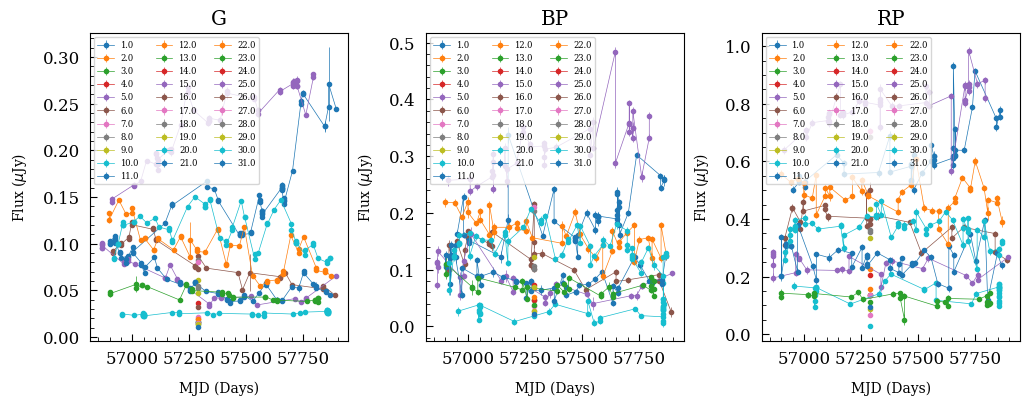

In [14]:
### MAKE FIGURE OF ONE LIGHT CURVE FOR GAIA ###

## First get the ids/names of sources that have Gaia multi-epoch observations.
object_ids = list(df_lc.data.index.levels[0]) # get list of objectids in multiIndex table
#print(object_ids)

fig = plt.figure(figsize=(12,4))
plt.subplots_adjust(wspace=0.3)
axs = [ fig.add_subplot(1,3,ii+1) for ii in range(3) ]
cmap = plt.get_cmap("Spectral")

for dd in object_ids:
    try:
    
        for bb,band in enumerate(["G","BP","RP"]):
        
            this_tab = df_lc.data.loc[dd,"Gaia {}".format(band.lower()),:].reset_index(inplace=False)
            t = Time(this_tab["time"] , format="mjd") # convert to time object
            #axs[bb].plot(t.mjd , this_tab["flux"] , "-" , linewidth=1 , markersize=0.1)
            axs[bb].errorbar(t.mjd , this_tab["flux"] , yerr=this_tab["err"] , fmt="-o",linewidth=0.5 , markersize=3 , label="{}".format(dd))
    except:
        pass

for ii in range(3):
    axs[ii].set_title(np.asarray(["G","BP","RP"])[ii])
    axs[ii].legend(fontsize=6 , ncol=3)
    axs[ii].set_xlabel("MJD (Days)" , fontsize=10)
    axs[ii].set_ylabel(r"Flux ($\mu$Jy)", fontsize=10)

plt.show()

### 3.2 ASAS-SN (all sky automated survey for supernovae) 
- has a website that can be manually searched; but no API
- magnitude range of this survey is not consistent with the magnitude range of our CLAGN so we have not put effort into making this work



### 3.3 Icecube Neutrinos
- has a 2008 - 2018 catalog which we can download and is small 
- https://icecube.wisc.edu/data-releases/2021/01/all-sky-point-source-icecube-data-years-2008-2018/

There are several catalogs (basically one for each year of IceCube data). The following code creates a large catalog by combining
all the yearly catalogs.
The IceCube catalog contains Neutrino detections with associated energy and time and approximate direction (which is uncertain by half-degree scales....). Usually, for active events only one or two Neutrinos are detected, which makes matching quite different compared to "photons". For our purpose, I suggest that we just list the top 3 events in energy that are within a given distance to the target.

The final __question__ is how we store this information. It is basically a time series (time vs. neutrino energy) for each source in the catalog. It is not clear to me how exactly to add it to the lightcurve object. For now, I added is similar to photometry. Storing time and energy, leaving error = 0. What is __not__ stored in this format is the distance or angular uncertainty of the event direction. 

In [15]:
%%time
#### LOAD EVENTS ####
# This loads the IceCube catalog, which is dispersed in different files.
# Each file has a list of events with their energy, time, and approximate direction.
icecube_events , _ = get_icecube_catalog(path="./data/icecube/icecube_10year_ps/")

# sort by Neutrino energy
icecube_events.sort(keys="energy_logGeV" , reverse=True)

Loading:  IC40_exp.csv
Loading:  IC59_exp.csv
Loading:  IC79_exp.csv
Loading:  IC86_III_exp.csv
Loading:  IC86_II_exp.csv
Loading:  IC86_IV_exp.csv
Loading:  IC86_I_exp.csv
Loading:  IC86_VII_exp.csv
Loading:  IC86_VI_exp.csv
Loading:  IC86_V_exp.csv
done
CPU times: user 11.8 s, sys: 314 ms, total: 12.1 s
Wall time: 12.1 s


In [16]:
### MATCH OBJECTS ###
# Here we match the objects to the IceCube catalog to extract the N highest energy events close
# to the objects' coordinates. We also want to include the errors in position of the IceCube
# events.

## Top N (in energy) events to selected
icecube_select_topN = 3

## create SkyCoord objects from event coordinates
c2 = SkyCoord(icecube_events["ra"], icecube_events["dec"], unit="deg", frame='icrs')

## Match
icecube_matches = []
icecube_matched = []
ii = 0
for cc,coord in enumerate(coords_list):

    # get all distances
    dist_angle =  coord.separation(c2)
    
    # make selection: here we have to also include errors on the
    # angles somehow.
    sel = np.where( (dist_angle.to(u.degree).value - icecube_events["AngErr"]) <= 0.0)[0]
    #print(len(sel))

    # select the top N events in energy. Note that we already sorted the table
    # by energy_logGeV. Hence we only have to pick the top N here.
    if len(sel) < icecube_select_topN:
        this_topN = len(sel)
    else:
        this_topN = icecube_select_topN * 1
    
    if len(sel) > 0:
        icecube_matches.append(icecube_events[sel[0:this_topN]])
        icecube_matches[ii]["Ang_match"] = dist_angle.to(u.degree).value[sel[0:this_topN]]
        icecube_matches[ii]["Ang_match"].unit = u.degree
        icecube_matched.append(cc)
        
        ii += 1
        
        
    else:
        pass # no match found
        print("No match found.")

        
## Add to lightcurve object:
ii = 0
for cc,coord in enumerate(coords_list):
    
    if cc in icecube_matched:
        ## Create single instance
        dfsingle = pd.DataFrame(
                                dict(flux=np.asarray(icecube_matches[ii]["energy_logGeV"]), # in log GeV
                                 err=np.repeat(0,len(icecube_matches[ii])), # in mJy
                                 time=np.asarray(icecube_matches[ii]["mjd"]), # in MJD
                                 #objectid=gaia_phot["input_object_name"][ii],
                                 objectid=np.repeat(cc+1, len(icecube_matches[ii])),
                                 band="IceCube"
                                    )
                    ).set_index(["objectid", "band", "time"])

        ## Append
        df_lc.append(dfsingle)
        
        ii += 1
    
print("IceCube Matched and added to lightcurve object.")

IceCube Matched and added to lightcurve object.


In [76]:
# Save or load the data frame
if SAVEDF:
    df_lc.pickle(pickle_file_name)
    print("Pickle file saved!")
else:
    df_lc = MultiIndexDFObject()
    #df_lc.load_pickle("data/dflc.pkl")
    df_lc.load_pickle(pickle_file_name)
    print("Pickle file loaded!")

Pickle file loaded!


## 4. Make plots of luminosity as a function of time
- model plots after https://arxiv.org/pdf/2111.09391.pdf


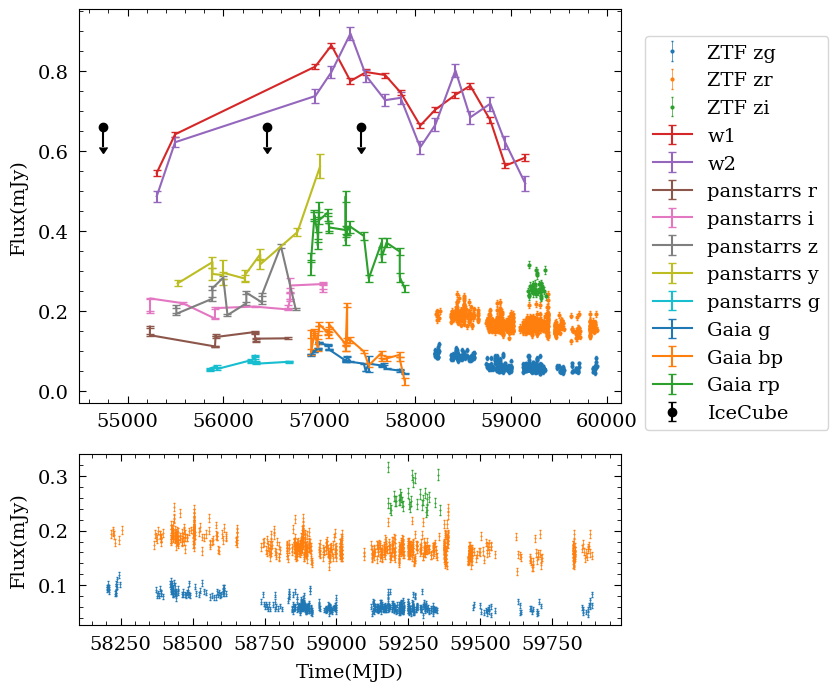

CPU times: user 897 ms, sys: 33.3 ms, total: 930 ms
Wall time: 937 ms


In [77]:
%%time
for ccount, coord in enumerate(coords_list):
    singleobj = df_lc.data.loc[(ccount+1),:,:]

    # Set up for plotting. We use the "mosaic" method so we can plot
    # the ZTF data in a subplot for better visibility.
    fig, axes = plt.subplot_mosaic(mosaic=[["A"],["A"],["B"]] , figsize=(7,8))
    plt.subplots_adjust(hspace=0.3 , wspace=0.3)

    # First check to see which bands we have in the dataframe
    availband = singleobj.index.unique('band')
    

    # Plot all the bands in the *main plot* (A)
    leg_handles_A = []
    max_list = [] # store maximum flux for each band
    ztf_minmax_tab = Table(names=["tmin","tmax","fluxmin","fluxmax"]) # store the min and max of the ZTF band fluxes and time
    has_ztf = False # flag to set to True if ZTF data is available.
    for l in range(len(availband)):
        band_lc = singleobj.loc[(ccount+1, availband[l]), :]
        #band_lc = singleobj.loc[availband[l], :] # above line doesn't work for me [ALF]
        band_lc.reset_index(inplace = True)

        # first clean dataframe to remove erroneous rows
        band_lc_clean = band_lc[band_lc['time'] < 65000]

        #before plotting need to scale the Kepler, K2, and TESS fluxes to the other available fluxes
        if availband[l] in ['Kepler', 'K2', 'TESS']:
            #remove outliers in the dataset
            bandlc_clip = band_lc_clean[(np.abs(stats.zscore(band_lc_clean['flux'])) < 3.0)]

            #find the maximum value of 'other bands'
            max_electrons = max(band_lc_clean.flux)
            factor = np.mean(max_list)/ max_electrons
            lh = axes["A"].errorbar(bandlc_clip.time, bandlc_clip.flux * factor, bandlc_clip.err* factor,
                                    capsize = 3.0,label = availband[l])
        elif availband[l] in ['zg','zr','zi']:
            max_list.append(max(band_lc_clean.flux)) 
            lh = axes["A"].errorbar(band_lc_clean.time, band_lc_clean.flux, band_lc_clean.err,
                                    capsize = 1.0, elinewidth=0.5,marker='o',markersize=2,linestyle='', label = 'ZTF '+str(availband[l]))
            ztf_minmax_tab.add_row( [np.min(band_lc_clean.time) , np.max(band_lc_clean.time) , np.min(band_lc_clean.flux) , np.max(band_lc_clean.flux) ] )
            has_ztf = True
            
            axes["B"].errorbar(band_lc_clean.time, band_lc_clean.flux, band_lc_clean.err,
                                    capsize = 1.0, elinewidth=0.5, marker='o',linestyle='',markersize=0.5,  label = 'ZTF '+str(availband[l]))
            
        elif availband[l] in ["IceCube"]:
            y = axes["A"].get_ylim()[0] + np.diff(axes["A"].get_ylim())*0.7
            dy = np.diff(axes["A"].get_ylim())/20
            lh = axes["A"].errorbar(band_lc_clean.time , np.repeat(y , len(band_lc_clean.time)) , yerr=dy, uplims=True ,
                                    fmt="o"  , label=availband[l] , color="black")
            
        else:
            max_list.append(max(band_lc_clean.flux)) 
            lh = axes["A"].errorbar(band_lc_clean.time, band_lc_clean.flux, band_lc_clean.err,
                                    capsize = 3.0, label = availband[l])

        leg_handles_A.append(lh)
    
    # Plot the ZTF bands in a separate plot to show their variability
    # more clearly. Can still also plot the rest, just change the x and
    # y axis limits. Only do this if ZTF is available for source.

    ## Do Axes
    
    #axes["A"].spines['top'].set_visible(False)
    #axes["A"].spines['right'].set_visible(False)
    axes["A"].set_ylabel('Flux(mJy)')
    
    axes["B"].set_ylabel('Flux(mJy)')
    axes["B"].set_xlabel('Time(MJD)')
    
    axes["B"].set_xlim( np.min(ztf_minmax_tab["tmin"])-100 , np.max(ztf_minmax_tab["tmax"])+100 )
    
    
    plt.legend(handles=leg_handles_A , bbox_to_anchor=(1.4,3.5))
    
    #save the plot to data/*.pdf
    savename = "data/lightcurve_{}.pdf".format(ccount+1)
    plt.savefig(savename, bbox_inches="tight")
    plt.show()
    
## TODO:
## - add running median to ZTF lightcurve. [ALF]


## ML Extension 
Consider training a ML model to do light curve classification based on this sample of CLAGN
 - once we figure out which bands these are likely to be observed in, could then have a optical + IR light curve classifier
 - what would the features of the light curve be?
 - what models are reasonable to test as light curve classifiers?
 - could we make also a sample of TDEs, SNe, flaring AGN? - then train the model to distinguish between these things?
 - need a sample of non-flaring light curves
 
After training the model:
 - would then need a sample of optical + IR light curves for "all" galaxies = big data to run the model on.

Some resources to consider:
- https://github.com/dirac-institute/ZTF_Boyajian
- https://ui.adsabs.harvard.edu/abs/2022AJ....164...68S/abstract
- https://ui.adsabs.harvard.edu/abs/2019ApJ...881L...9F/abstract



## Citations

to the various codes used (astroquery etc.)